In [1]:
import numpy as np
import cv2, os, time
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

from compute_disparity import *
from project3D import *

import metrics as mx
norm = lambda x : (x - x.min())/(x.max() - x.min())

import plotly.express as px

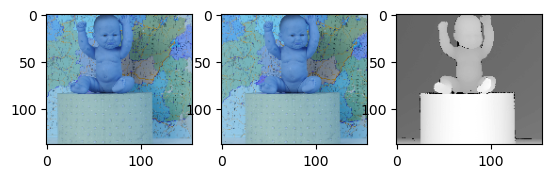

In [2]:
left_img_path = '../HW2/files/images/input/2/view1.png'
right_img_path = '../HW2/files/images/input/2/view0.png'
gnd_img_path = '../HW2/files/images/input/2/ground.png'

l_img = cv2.imread(left_img_path)

height, width = l_img.shape[:2]
new_height, new_width = int(height / 8), int(width / 8)

l_img = cv2.resize(l_img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

r_img = cv2.imread(right_img_path)
r_img = cv2.resize(r_img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

ground_img = cv2.imread(gnd_img_path, cv2.IMREAD_GRAYSCALE)
ground_img = cv2.resize(ground_img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)


fig,ax = plt.subplots(1,3)
ax[0].imshow(l_img)
ax[1].imshow(r_img)
ax[2].imshow(ground_img,cmap='gray')
plt.show()

In [3]:
start_ = time.time()
disp_img = NaiveStereoVision(l_img, r_img, k_size = 7, max_offset = 100, scale = 1)
end_ = time.time()

print('Ellapsed Time', end_-start_)

100%|██████████| 132/132 [00:11<00:00, 11.80it/s]


Ellapsed Time 11.225024223327637


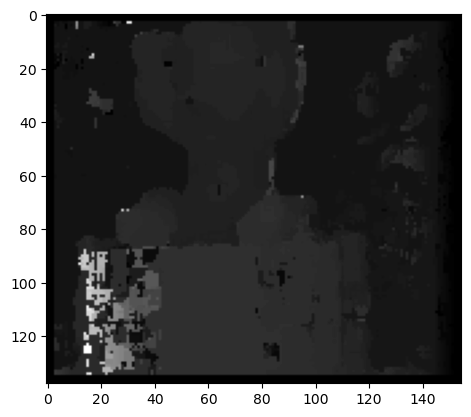

In [4]:
plt.imshow(disp_img,cmap='gray')
#plt.savefig('disps/Naive_{}.png'.format(folder_name))
plt.show()

# Dynamic Programming

### Get Row, Forward match, Backtrack repeat

In [5]:
start = time.time()
disp_img_dyn = dynamic_disparity(l_img, r_img)
end = time.time()

print('Ellapsed Time', end-start)

100%|██████████| 138/138 [01:36<00:00,  1.43it/s]

Ellapsed Time 96.68809390068054


In [ ]:
#np.savetxt('xyz/DP_{0}_{1}_seconds.xyz'.format(folder_name, end - start), project_disparity_to_3d(disp_img_dyn[:,:,0]), delimiter = ' ')

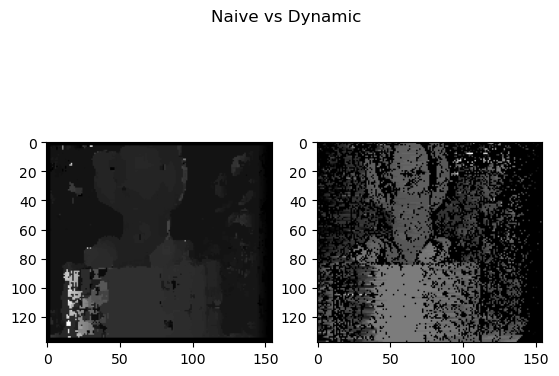

In [6]:
try:
    disp_img_dyn = disp_img_dyn[:,:,0]
except:
    pass

fig,ax = plt.subplots(1,2)
ax[0].imshow(disp_img,cmap='gray')
ax[1].imshow(disp_img_dyn,cmap='gray')
plt.suptitle('Naive vs Dynamic')
plt.show()

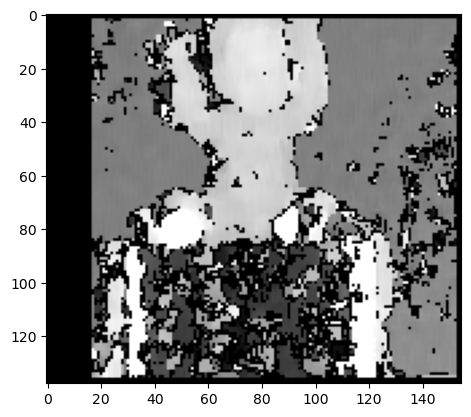

In [15]:
stereo = cv2.StereoBM_create(numDisparities = 16, blockSize = 5)
cv_disp = stereo.compute(cv2.cvtColor(r_img, cv2.COLOR_BGR2GRAY), cv2.cvtColor(l_img, cv2.COLOR_BGR2GRAY))

cv_disp = ((cv_disp - cv_disp.min())/(cv_disp.max() - cv_disp.min()))
cv_disp = (cv_disp*255).astype(int)

plt.imshow(cv_disp,'gray')
plt.show()

In [ ]:


comparison_matrix = [['Method','Naive','Dynamic','OpenCV']]
for mx_name, func in zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'], [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim]):
    comparison_matrix.append([mx_name,
                              func(norm(disp_img),norm(ground_img)),
                              func(norm(disp_img_dyn),norm(ground_img)),
                              func(norm(cv_disp),norm(ground_img))])
print('Naive vs Dynamic vs OpenCV')
pd.DataFrame(comparison_matrix)

# Compute Plots, Correlations

### Naive Evaluation

In [2]:
#window_size,time,metrices
new_width, new_height = 250,250
naive_result = []

for img_idx in range(1,7):
    left_img_path = '../HW2/files/images/input/{0}/view1.png'.format(img_idx)
    right_img_path = '../HW2/files/images/input/{0}/view0.png'.format(img_idx)
    gnd_img_path = '../HW2/files/images/input/{0}/ground.png'.format(img_idx)

    l_img = cv2.resize(cv2.imread(left_img_path), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    r_img = cv2.resize(cv2.imread(right_img_path), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    ground_img = cv2.resize(cv2.imread(gnd_img_path, cv2.IMREAD_GRAYSCALE), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    
    c = 0     
    
    for win_size in [5,9,13,17]:
        for max_offset in [25,50,75]:
            start_ = time.time()
            disp_img = NaiveStereoVision(l_img, r_img, k_size = win_size, max_offset = max_offset, show_tqdm = False)
            end_ = time.time()
            
            naive_time = end_ - start_
            
            row = [img_idx, l_img, ground_img]

            row += [func(norm(disp_img),norm(ground_img)) for mx_name, func in zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                                                                            [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]  
            row+= [disp_img,win_size,max_offset,naive_time]
    
            c+=1

            naive_result.append(row)

            print({'img_idx':img_idx,'params':[win_size,max_offset]},{c}, end = '\r')

KeyboardInterrupt: 

In [2]:

import pickle

#with open('naive_result.pickle', 'wb') as handle:
#    pickle.dump(naive_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('naive_result.pickle', 'rb') as handle:
    naive_result = pickle.load(handle)


In [3]:
naive_df = pd.DataFrame(naive_result, columns = ['idx','l_img','gnd_img','ssd ', 
                                      'mse ', 'psnr', 'corr', 'ssim',
                                      'disp_img','win_size','max_offset','naive_time'])

### Quality Analysis

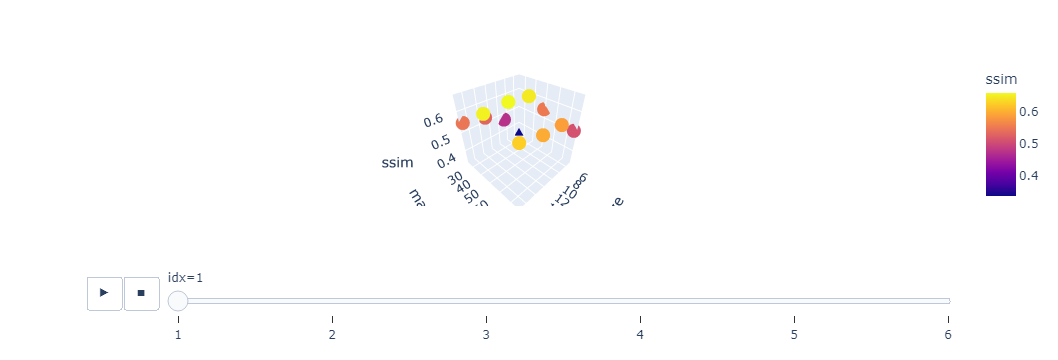

In [4]:
import plotly.express as px
import pandas as pd


fig = px.scatter_3d(naive_df, x='win_size', y='max_offset', z='ssim', color = 'ssim',animation_frame='idx')
fig.write_html("naive_data.html")
fig.show()

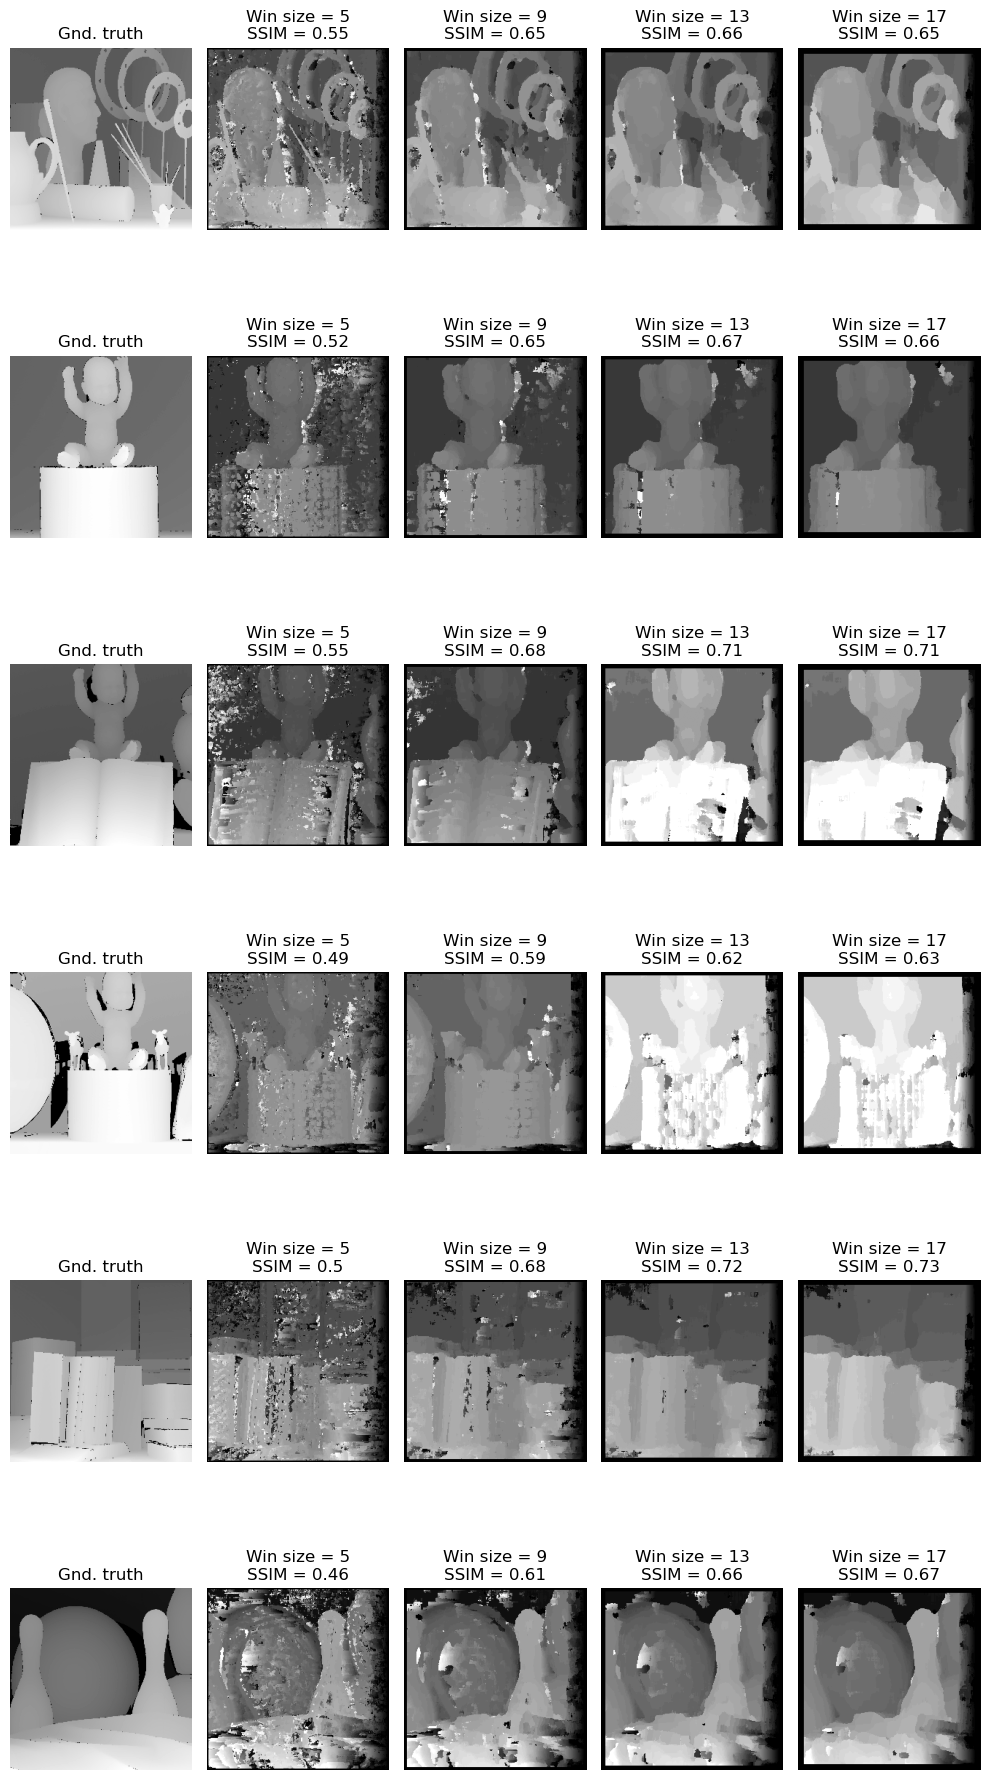

In [5]:
fig, ax = plt.subplots(6, 5, figsize=(10, 20), tight_layout=True)

for idx in range(1,7):
    gnd_img = naive_df[naive_df['idx']==idx].iloc[0]['gnd_img']
    ax[idx-1,0].imshow(gnd_img,cmap='gray')
    ax[idx-1,0].axis('off')
    ax[idx-1,0].set_title("Gnd. truth")
    for i,win_size in enumerate([5,9,13,17]):
        df_min = naive_df[np.logical_and(naive_df['win_size']==win_size,naive_df['idx']==idx)]
        row = df_min.iloc[df_min['ssim'].argmax()]
        img = row['disp_img']   
        
        ax[idx-1,i+1].imshow(img,cmap='gray')
        ax[idx-1,i+1].axis('off')
        ax[idx-1,i+1].set_title("Win size = {0}\nSSIM = {1}".format(row['win_size'],np.round(row['ssim'],2)))

### Time analysis

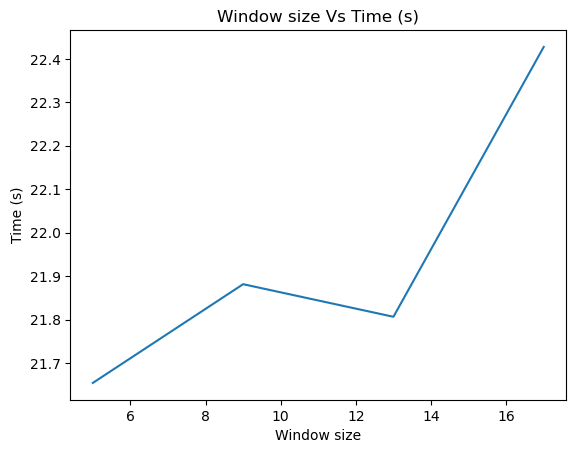

In [6]:
plt.plot([5,9,13,17], [naive_df[naive_df['win_size']==i]['naive_time'].mean() for i in [5,9,13,17]])
plt.title('Window size Vs Time (s)')
plt.xlabel('Window size')
plt.ylabel('Time (s)')
plt.show()

idx                                                           1
l_img         [[[42, 43, 104], [38, 42, 93], [38, 43, 93], [...
gnd_img       [[79, 80, 79, 79, 79, 79, 79, 79, 79, 79, 79, ...
ssd                                                 5568.496933
mse                                                    0.089096
psnr                                                  58.632224
corr                                                   0.268086
ssim                                                   0.659657
disp_img      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
win_size                                                     13
max_offset                                                   50
naive_time                                            21.981749
Name: 7, dtype: object


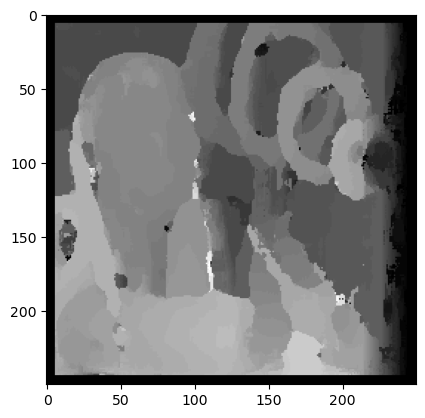

In [7]:
min_df = naive_df[naive_df['idx']==1]
row = min_df.loc[min_df['ssim'].argmax()]
print(row)
plt.imshow(norm(row['disp_img']),cmap = 'gray')
plt.show()

In [18]:
for idx in tqdm(range(1,7)):
    min_df = naive_df[naive_df['idx']==idx]
    row = min_df.iloc[min_df['ssim'].argmax()]
    all_points = project_disparity_to_3d(norm(row['disp_img']))
    all_norms = project_disparity_to_3d_norm(norm(row['disp_img']))
    s = 'ply\n\
        format ascii 1.0\n\
        element vertex {0}\n\
        property float x\n\
        property float y\n\
        property float z\n\
        property float nx\n\
        property float ny\n\
        property float nz\nend_header\n'.format(len(all_points))

    for p, n in zip(all_points, all_norms):
        s += ' '.join(["{:0.14f}".format(x) for x in p + n]) + '\n'

    with open('xyz/{0}_naive_points.ply'.format(idx), 'w') as the_file:
        the_file.write(s)

100%|██████████| 6/6 [00:44<00:00,  7.38s/it]


# Dynamic Method

In [ ]:
#window_size,time,metrices
new_width, new_height = 250,250
dynamic_result = []

for img_idx in range(1,7):
    left_img_path = '../HW2/files/images/input/{0}/view1.png'.format(img_idx)
    right_img_path = '../HW2/files/images/input/{0}/view0.png'.format(img_idx)
    gnd_img_path = '../HW2/files/images/input/{0}/ground.png'.format(img_idx)

    l_img = cv2.resize(cv2.imread(left_img_path), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    r_img = cv2.resize(cv2.imread(right_img_path), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    ground_img = cv2.resize(cv2.imread(gnd_img_path, cv2.IMREAD_GRAYSCALE), (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    
    for lmbd in [1,5,9,13]:
        start_ = time.time()
        disp_img = dynamic_disparity(l_img, r_img, show_tqdm = True, lmbd = lmbd)[:,:,0]
        end_ = time.time()

        naive_time = end_ - start_

        row = [img_idx, l_img, ground_img]

        row += [func(norm(disp_img),norm(ground_img)) for mx_name, func in zip(['ssd ', 'mse ', 'psnr', 'corr', 'ssim'],
                                                                        [mx.ssd, mx.mse, mx.psnr, mx.corr, mx.ssim])]  
        row+= [disp_img,lmbd,naive_time]

        dynamic_result.append(row)

        print({'img_idx':img_idx,'params':[lmbd]}, end = '\r')

 12%|█▏        | 31/250 [00:57<06:30,  1.78s/it]

In [ ]:

import pickle

#with open('dynamic_result.pickle', 'wb') as handle:
#    pickle.dump(dynamic_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dynamic_result.pickle', 'rb') as handle:
    dynamic_result = pickle.load(handle)


In [17]:
dynamic_df = pd.DataFrame(dynamic_result, columns = ['idx','l_img','gnd_img','ssd ', 
                                      'mse ', 'psnr', 'corr', 'ssim',
                                      'disp_img','lambda','naive_time'])

### Quality analysis

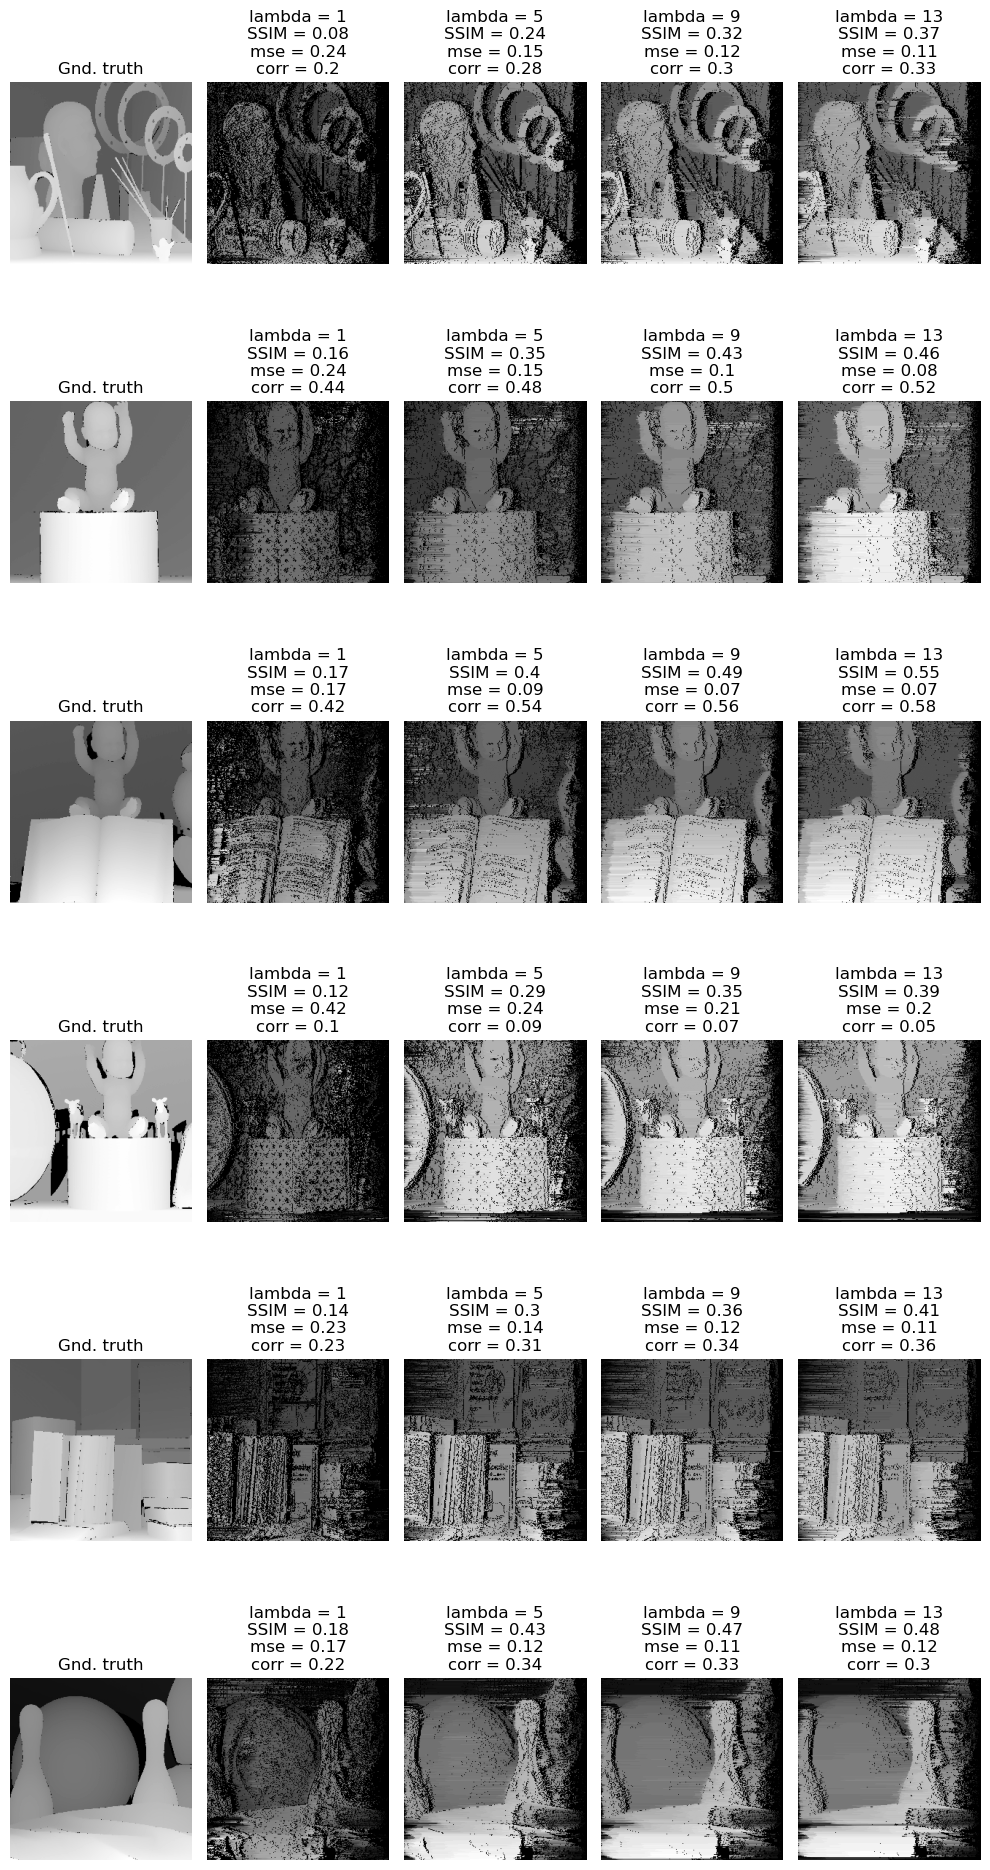

In [31]:
fig, ax = plt.subplots(6, 5, figsize=(10, 20), tight_layout=True)

for idx in range(1,7):
    gnd_img = dynamic_df[dynamic_df['idx']==idx].iloc[0]['gnd_img']
    ax[idx-1,0].imshow(gnd_img,cmap='gray')
    ax[idx-1,0].axis('off')
    ax[idx-1,0].set_title("Gnd. truth")
    for i,win_size in enumerate([1,5,9,13]):
        df_min = dynamic_df[np.logical_and(dynamic_df['lambda']==win_size,dynamic_df['idx']==idx)]
        row = df_min.iloc[df_min['ssim'].argmax()]
        img = row['disp_img']   
        
        ax[idx-1,i+1].imshow(img,cmap='gray')
        ax[idx-1,i+1].axis('off')
        ax[idx-1,i+1].set_title("lambda = {0}\nSSIM = {1}\nmse = {2}\ncorr = {3}".format(row['lambda'],
                                                                  np.round(row['ssim'],2), np.round(row['mse '],2),np.round(row['corr'],2)
                                                                   ))

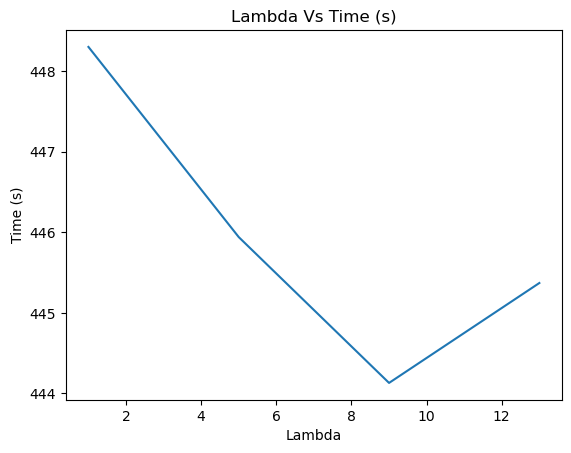

In [33]:
plt.plot([1,5,9,13], [dynamic_df[dynamic_df['lambda']==i]['naive_time'].mean() for i in [1,5,9,13]])
plt.title('Lambda Vs Time (s)')
plt.xlabel('Lambda')
plt.ylabel('Time (s)')
plt.show()

### 3Dpoint

In [34]:
for idx in tqdm(range(1,7)):
    min_df = dynamic_df[dynamic_df['idx']==idx]
    row = min_df.iloc[min_df['ssim'].argmax()]
    all_points = project_disparity_to_3d(norm(row['disp_img']))
    all_norms = project_disparity_to_3d_norm(norm(row['disp_img']))
    s = 'ply\n\
        format ascii 1.0\n\
        element vertex {0}\n\
        property float x\n\
        property float y\n\
        property float z\n\
        property float nx\n\
        property float ny\n\
        property float nz\nend_header\n'.format(len(all_points))

    for p, n in zip(all_points, all_norms):
        s += ' '.join(["{:0.14f}".format(x) for x in p + n]) + '\n'

    with open('xyz/{0}_dynamic_points.ply'.format(idx), 'w') as the_file:
        the_file.write(s)

100%|██████████| 6/6 [00:42<00:00,  7.05s/it]
